## Imports

In [1]:
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
import tensorflow as tf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import cv2
from tensorflow.keras.preprocessing import image
import tensorflow.keras.backend as K

from sklearn.metrics import roc_auc_score, f1_score, classification_report, confusion_matrix
import seaborn as sns

In [2]:
tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [3]:
df_metadata = pd.read_csv("./Chest_xray_Corona_Metadata.csv", index_col=0)
df_summary = pd.read_csv("./Chest_xray_Corona_dataset_Summary.csv", index_col=0)

In [4]:
df_metadata.head()

,X_ray_image_name,Label,Dataset_type,Label_2_Virus_category,Label_1_Virus_category
0,IM-0128-0001.jpeg,Normal,TRAIN,NaN,NaN
1,IM-0127-0001.jpeg,Normal,TRAIN,NaN,NaN
2,IM-0125-0001.jpeg,Normal,TRAIN,NaN,NaN
3,IM-0122-0001.jpeg,Normal,TRAIN,NaN,NaN
4,IM-0119-0001.jpeg,Normal,TRAIN,NaN,NaN


In [5]:
df_summary

,Label,Label_1_Virus_category,Label_2_Virus_category,Image_Count
0,Normal,NaN,NaN,1576
1,Pnemonia,Stress-Smoking,ARDS,2
2,Pnemonia,Virus,NaN,1493
3,Pnemonia,Virus,COVID-19,58
4,Pnemonia,Virus,SARS,4
5,Pnemonia,bacteria,NaN,2772
6,Pnemonia,bacteria,Streptococcus,5


In [6]:
def sel_image_plot(label='Normal', idx=0):
    
    """
    Input: Label of the image we want to select.
           Index of the image we want to select.
    Output: Plot of an image.
    """
    
    try:
        image_list = df_metadata[(df_metadata['Label'] == label) & (df_metadata['Dataset_type'] == 'TRAIN')]
        image_name= image_list['X_ray_image_name'].reset_index(drop=True)[idx]
        plt.imshow(plt.imread('./Coronahack-Chest-XRay-Dataset/train/' + image_name))
        plt.title('X-Ray of a pacient with label \'{0}\' from the train dataset'.format(label))
        plt.show()
        
    except KeyError:
        print('Index not in range.')

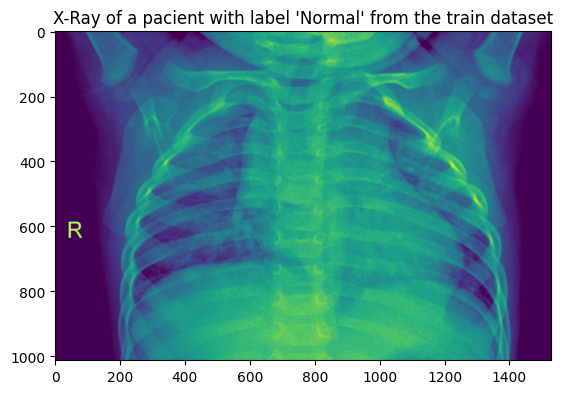

In [7]:
sel_image_plot(idx=0)

In [8]:
def sel_train_test(dataframe, train_test):
    
    """
    Inputs: Dataframe and a string (test or train).
    Outputs: Only the test or train examples in the dataframe.
    """
    
    dataframe_transformed = dataframe[dataframe['Dataset_type'] == train_test.upper()]
    
    return dataframe_transformed

In [9]:
def preprocess_img(img):
    return

In [10]:
IMAGE_DIM = 400

In [11]:
PATH = './Coronahack-Chest-XRay-Dataset/'
BATCH_SIZE = 2

# Experiment with your own parameters to reach 99.9% validation accuracy or better
train_datagen = ImageDataGenerator(rescale=1./255,
      rotation_range=40,
      width_shift_range=0.2,
      height_shift_range=0.2,
      shear_range=0.2,
      zoom_range=0.2,
      horizontal_flip=True,
      validation_split=0.1,
      fill_mode='nearest')

train_generator = train_datagen.flow_from_dataframe(dataframe=sel_train_test(df_metadata, 'train'),
                                                    x_col='X_ray_image_name',
                                                    y_col='Label',
                                                    color_mode='rgb',
                                                    class_mode='binary',
                                                    target_size=(IMAGE_DIM, IMAGE_DIM),
                                                    batch_size=BATCH_SIZE,
                                                    shuffle=True,
                                                    seed=1234,
                                                    subset='training', 
                                                    directory=PATH + 'train/')


val_generator = train_datagen.flow_from_dataframe(dataframe=sel_train_test(df_metadata, 'train'),
                                                    x_col='X_ray_image_name',
                                                    y_col='Label',
                                                    color_mode='rgb',
                                                    class_mode='binary',
                                                    target_size=(IMAGE_DIM, IMAGE_DIM),
                                                    batch_size=BATCH_SIZE,
                                                    shuffle=True,
                                                    seed=1234,
                                                    subset='validation', 
                                                    directory=PATH + 'train/')

test_datagen = ImageDataGenerator(rescale=1./255, horizontal_flip=True)


test_generator = test_datagen.flow_from_dataframe(dataframe=sel_train_test(df_metadata, 'test'),
                                                  x_col='X_ray_image_name',
                                                  y_col='Label',
                                                  color_mode='rgb',
                                                  class_mode='binary',
                                                  target_size=(IMAGE_DIM, IMAGE_DIM),
                                                  batch_size=BATCH_SIZE,
                                                  shuffle=False, 
                                                  directory=PATH + 'test/')

Found 4758 validated image filenames belonging to 2 classes.
Found 528 validated image filenames belonging to 2 classes.
Found 624 validated image filenames belonging to 2 classes.


In [12]:
def model_inception():
    
    """
    Model InceptionV3.
    """
    
    inputs = tf.keras.layers.Input((IMAGE_DIM, IMAGE_DIM, 3))
    base_model = tf.keras.applications.InceptionV3(input_tensor=inputs, include_top=False,
                                                 weights='imagenet',
                                                 input_shape=(IMAGE_DIM, IMAGE_DIM, 3))
    
    #x = base_model(inputs)
    
    x = tf.keras.layers.Flatten()(base_model.output)
    x = tf.keras.layers.Dense(256, activation='relu')(x)
    
    output = tf.keras.layers.Dense(1, activation='sigmoid')(x)
    
    model = tf.keras.models.Model(inputs=inputs, outputs=output)

    return model

In [13]:
model = model_inception()

In [14]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 400, 400, 3)]        0         []                            
                                                                                                  
 conv2d (Conv2D)             (None, 199, 199, 32)         864       ['input_1[0][0]']             
                                                                                                  
 batch_normalization (Batch  (None, 199, 199, 32)         96        ['conv2d[0][0]']              
 Normalization)                                                                                   
                                                                                                  
 activation (Activation)     (None, 199, 199, 32)         0         ['batch_normalization[0][0

 conv2d_11 (Conv2D)          (None, 47, 47, 32)           6144      ['average_pooling2d[0][0]']   
                                                                                                  
 batch_normalization_5 (Bat  (None, 47, 47, 64)           192       ['conv2d_5[0][0]']            
 chNormalization)                                                                                 
                                                                                                  
 batch_normalization_7 (Bat  (None, 47, 47, 64)           192       ['conv2d_7[0][0]']            
 chNormalization)                                                                                 
                                                                                                  
 batch_normalization_10 (Ba  (None, 47, 47, 96)           288       ['conv2d_10[0][0]']           
 tchNormalization)                                                                                
          

                                                                                                  
 activation_17 (Activation)  (None, 47, 47, 96)           0         ['batch_normalization_17[0][0]
                                                                    ']                            
                                                                                                  
 activation_18 (Activation)  (None, 47, 47, 64)           0         ['batch_normalization_18[0][0]
                                                                    ']                            
                                                                                                  
 mixed1 (Concatenate)        (None, 47, 47, 288)          0         ['activation_12[0][0]',       
                                                                     'activation_14[0][0]',       
                                                                     'activation_17[0][0]',       
          

                                                                                                  
 conv2d_28 (Conv2D)          (None, 47, 47, 96)           55296     ['activation_27[0][0]']       
                                                                                                  
 batch_normalization_28 (Ba  (None, 47, 47, 96)           288       ['conv2d_28[0][0]']           
 tchNormalization)                                                                                
                                                                                                  
 activation_28 (Activation)  (None, 47, 47, 96)           0         ['batch_normalization_28[0][0]
                                                                    ']                            
                                                                                                  
 conv2d_26 (Conv2D)          (None, 23, 23, 384)          995328    ['mixed2[0][0]']              
          

 conv2d_30 (Conv2D)          (None, 23, 23, 192)          147456    ['mixed3[0][0]']              
                                                                                                  
 conv2d_33 (Conv2D)          (None, 23, 23, 192)          172032    ['activation_32[0][0]']       
                                                                                                  
 conv2d_38 (Conv2D)          (None, 23, 23, 192)          172032    ['activation_37[0][0]']       
                                                                                                  
 conv2d_39 (Conv2D)          (None, 23, 23, 192)          147456    ['average_pooling2d_3[0][0]'] 
                                                                                                  
 batch_normalization_30 (Ba  (None, 23, 23, 192)          576       ['conv2d_30[0][0]']           
 tchNormalization)                                                                                
          

                                                                    ']                            
                                                                                                  
 average_pooling2d_4 (Avera  (None, 23, 23, 768)          0         ['mixed4[0][0]']              
 gePooling2D)                                                                                     
                                                                                                  
 conv2d_40 (Conv2D)          (None, 23, 23, 192)          147456    ['mixed4[0][0]']              
                                                                                                  
 conv2d_43 (Conv2D)          (None, 23, 23, 192)          215040    ['activation_42[0][0]']       
                                                                                                  
 conv2d_48 (Conv2D)          (None, 23, 23, 192)          215040    ['activation_47[0][0]']       
          

                                                                                                  
 activation_52 (Activation)  (None, 23, 23, 160)          0         ['batch_normalization_52[0][0]
                                                                    ']                            
                                                                                                  
 activation_57 (Activation)  (None, 23, 23, 160)          0         ['batch_normalization_57[0][0]
                                                                    ']                            
                                                                                                  
 average_pooling2d_5 (Avera  (None, 23, 23, 768)          0         ['mixed5[0][0]']              
 gePooling2D)                                                                                     
                                                                                                  
 conv2d_50

 batch_normalization_62 (Ba  (None, 23, 23, 192)          576       ['conv2d_62[0][0]']           
 tchNormalization)                                                                                
                                                                                                  
 batch_normalization_67 (Ba  (None, 23, 23, 192)          576       ['conv2d_67[0][0]']           
 tchNormalization)                                                                                
                                                                                                  
 activation_62 (Activation)  (None, 23, 23, 192)          0         ['batch_normalization_62[0][0]
                                                                    ']                            
                                                                                                  
 activation_67 (Activation)  (None, 23, 23, 192)          0         ['batch_normalization_67[0][0]
          

                                                                                                  
 conv2d_71 (Conv2D)          (None, 11, 11, 320)          552960    ['activation_70[0][0]']       
                                                                                                  
 conv2d_75 (Conv2D)          (None, 11, 11, 192)          331776    ['activation_74[0][0]']       
                                                                                                  
 batch_normalization_71 (Ba  (None, 11, 11, 320)          960       ['conv2d_71[0][0]']           
 tchNormalization)                                                                                
                                                                                                  
 batch_normalization_75 (Ba  (None, 11, 11, 192)          576       ['conv2d_75[0][0]']           
 tchNormalization)                                                                                
          

                                                                                                  
 activation_82 (Activation)  (None, 11, 11, 384)          0         ['batch_normalization_82[0][0]
                                                                    ']                            
                                                                                                  
 activation_83 (Activation)  (None, 11, 11, 384)          0         ['batch_normalization_83[0][0]
                                                                    ']                            
                                                                                                  
 batch_normalization_84 (Ba  (None, 11, 11, 192)          576       ['conv2d_84[0][0]']           
 tchNormalization)                                                                                
                                                                                                  
 activatio

                                                                                                  
 activation_88 (Activation)  (None, 11, 11, 384)          0         ['batch_normalization_88[0][0]
                                                                    ']                            
                                                                                                  
 activation_91 (Activation)  (None, 11, 11, 384)          0         ['batch_normalization_91[0][0]
                                                                    ']                            
                                                                                                  
 activation_92 (Activation)  (None, 11, 11, 384)          0         ['batch_normalization_92[0][0]
                                                                    ']                            
                                                                                                  
 batch_nor

In [15]:
model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath='./ckpt/checkpoint.model.keras',
    save_weights_only=True,
    monitor='val_loss',
    mode='max',
    save_best_only=True,
)

In [16]:
model.compile(loss='binary_crossentropy', 
              optimizer=tf.keras.optimizers.Adamax(learning_rate=2e-5),
              metrics=['accuracy'])

history = model.fit(train_generator, validation_data=val_generator, epochs=10, callbacks=model_checkpoint_callback)

Epoch 1/10


I0000 00:00:1710870598.541234  168869 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


2379/2379 [==============================] - 165s 61ms/step - loss: 0.2614 - accuracy: 0.8890 - val_loss: 0.8301 - val_accuracy: 0.6136
Epoch 2/10
2379/2379 [==============================] - 141s 59ms/step - loss: 0.1846 - accuracy: 0.9277 - val_loss: 1.0939 - val_accuracy: 0.5701
Epoch 3/10
2379/2379 [==============================] - 144s 60ms/step - loss: 0.1439 - accuracy: 0.9422 - val_loss: 1.5609 - val_accuracy: 0.4943
Epoch 4/10
2379/2379 [==============================] - 141s 59ms/step - loss: 0.1362 - accuracy: 0.9449 - val_loss: 0.7595 - val_accuracy: 0.6837
Epoch 5/10
2379/2379 [==============================] - 143s 60ms/step - loss: 0.1191 - accuracy: 0.9531 - val_loss: 1.2072 - val_accuracy: 0.6856
Epoch 6/10
2379/2379 [==============================] - 143s 60ms/step - loss: 0.1125 - accuracy: 0.9559 - val_loss: 1.5616 - val_accuracy: 0.5966
Epoch 7/10
2379/2379 [==============================] - 142s 60ms/step - loss: 0.0992 - accuracy: 0.9613 - val_loss: 0.4368 - val

In [72]:
model.load_weights('./ckpt/checkpoint.model.keras')

Text(0, 0.5, 'Accuracy')

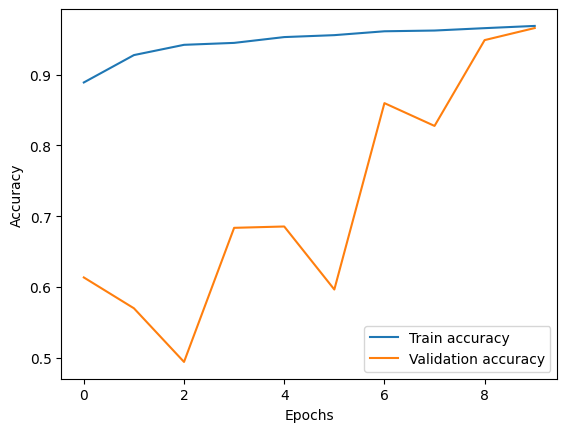

In [73]:
plt.plot(history.history["accuracy"], label="Train accuracy")
plt.plot(history.history["val_accuracy"], label="Validation accuracy")
plt.legend()
plt.xlabel("Epochs")
plt.ylabel("Accuracy")

Text(0, 0.5, 'Loss')

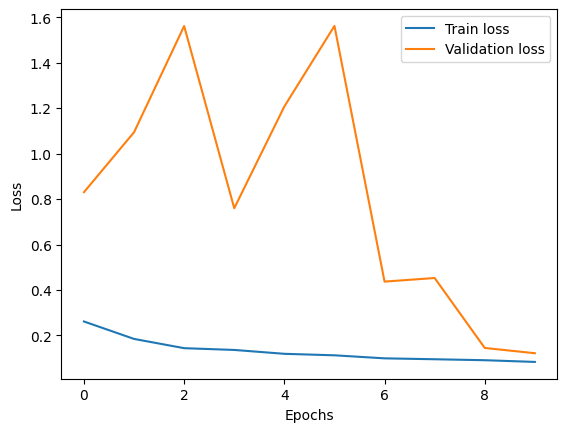

In [74]:
plt.plot(history.history["loss"], label="Train loss")
plt.plot(history.history["val_loss"], label="Validation loss")
plt.legend()
plt.xlabel("Epochs")
plt.ylabel("Loss")

In [75]:
predictions = model.predict(test_generator)

312/312 [==============================] - 6s 18ms/step


In [76]:
predictions = (predictions > 0.5).astype(int).reshape(-1,)

In [77]:
true_labels = [False if x=="Normal" else True for x in sel_train_test(df_metadata, 'test')["Label"]]

In [78]:
print("Results on test set:")
print(classification_report(true_labels, predictions, target_names=["Normal", "Pnemonia"]))
print("ROC AUC score:   ",roc_auc_score(true_labels, predictions))
print("F1 score:", f1_score(true_labels, predictions))

Results on test set:
              precision    recall  f1-score   support

      Normal       0.88      0.83      0.85       234
    Pnemonia       0.90      0.93      0.92       390

    accuracy                           0.89       624
   macro avg       0.89      0.88      0.88       624
weighted avg       0.89      0.89      0.89       624

ROC AUC score:    0.8799145299145299
F1 score: 0.9155107187894073


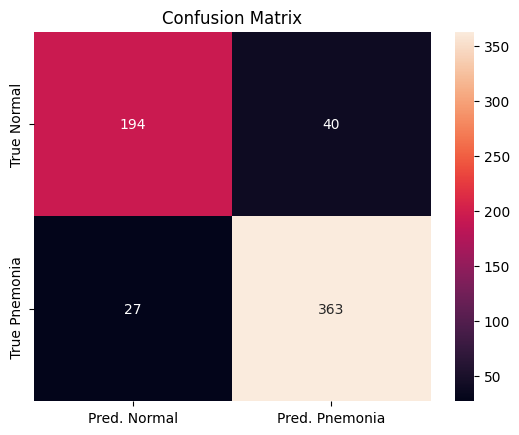

In [79]:
conf_matrix = confusion_matrix(true_labels, predictions)
sns.heatmap(conf_matrix,
            xticklabels = ["Pred. Normal", "Pred. Pnemonia"],
            yticklabels =["True Normal", " True Pnemonia"],
            annot=True,fmt='g')
plt.title('Confusion Matrix')
plt.show()

In [80]:
file_name_1 = df_metadata[(df_metadata['Label'] == 'Pnemonia') & 
            (df_metadata['Dataset_type'] == 'TEST')].sample(1).reset_index(drop=True).iloc[0, 0]

In [81]:
file_name_1 = 'person108_bacteria_507.jpeg'

In [82]:
df_metadata[df_metadata['X_ray_image_name'] == file_name_1]

,X_ray_image_name,Label,Dataset_type,Label_2_Virus_category,Label_1_Virus_category
5717,person108_bacteria_507.jpeg,Pnemonia,TEST,NaN,bacteria


In [83]:
img_saliency = cv2.imread('./Coronahack-Chest-XRay-Dataset/test/' + file_name_1)

In [84]:
img_saliency = cv2.resize(img_saliency, (IMAGE_DIM, IMAGE_DIM))
img_saliency = img_saliency / 255.
img_saliency_batched = np.expand_dims(img_saliency, axis=0)

In [85]:
model.predict(img_saliency_batched.astype(np.float32))

1/1 [==============================] - 0s 28ms/step


array([[0.99999917]], dtype=float32)

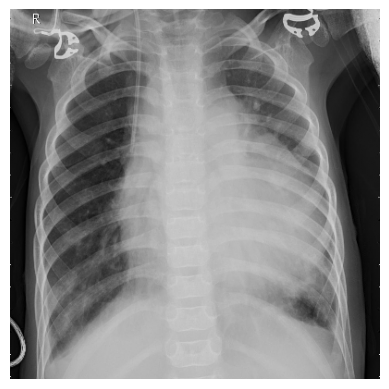

In [86]:
plt.imshow(img_saliency)
plt.axis('off')
plt.show()

In [87]:
class_index = 1
num_classes = 1

# convert to one hot representation to match our softmax activation in the model definition
expected_output = tf.one_hot([class_index] * img_saliency_batched.shape[0], num_classes)

with tf.GradientTape() as tape:
    # cast image to float
    inputs = tf.cast(img_saliency_batched, tf.float32)

    # watch the input pixels
    tape.watch(inputs)

    # generate the predictions
    predictions = model(inputs)

    # get the loss
    loss = tf.keras.losses.binary_crossentropy(
        expected_output, predictions
    )

# get the gradient with respect to the inputs
gradients = tape.gradient(loss, inputs)

In [88]:
# reduce the RGB image to grayscale
grayscale_tensor = tf.reduce_sum(tf.abs(gradients), axis=-1)

# normalize the pixel values to be in the range [0, 255].
# the max value in the grayscale tensor will be pushed to 255.
# the min value will be pushed to 0.
normalized_tensor = tf.cast(
    255
    * (grayscale_tensor - tf.reduce_min(grayscale_tensor))
    / (tf.reduce_max(grayscale_tensor) - tf.reduce_min(grayscale_tensor)),
    tf.uint8,
)

# remove the channel dimension to make the tensor a 2d tensor
normalized_tensor = tf.squeeze(normalized_tensor)

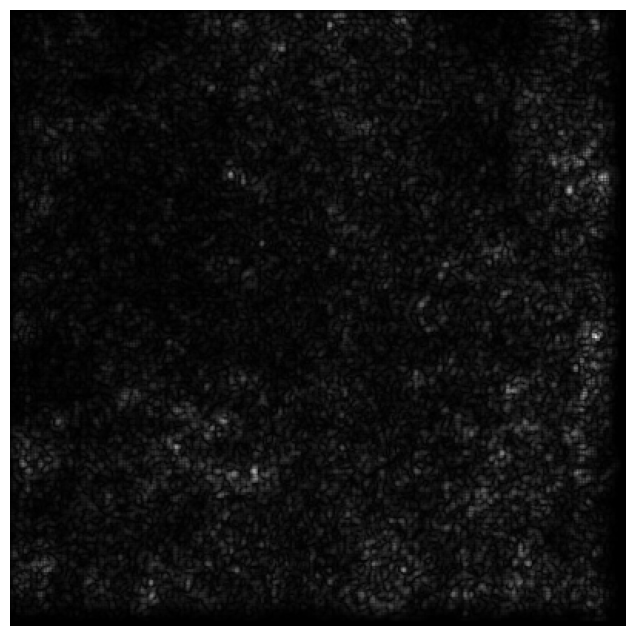

In [89]:
plt.figure(figsize=(8, 8))
plt.axis('off')
plt.imshow(normalized_tensor, cmap='gray')
plt.show()

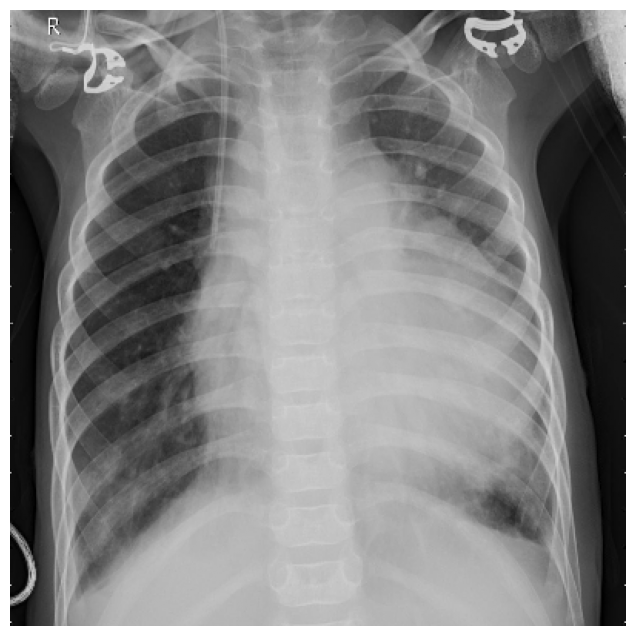

In [90]:
plt.figure(figsize=(8, 8))
plt.imshow(img_saliency)
plt.axis('off')
plt.show()

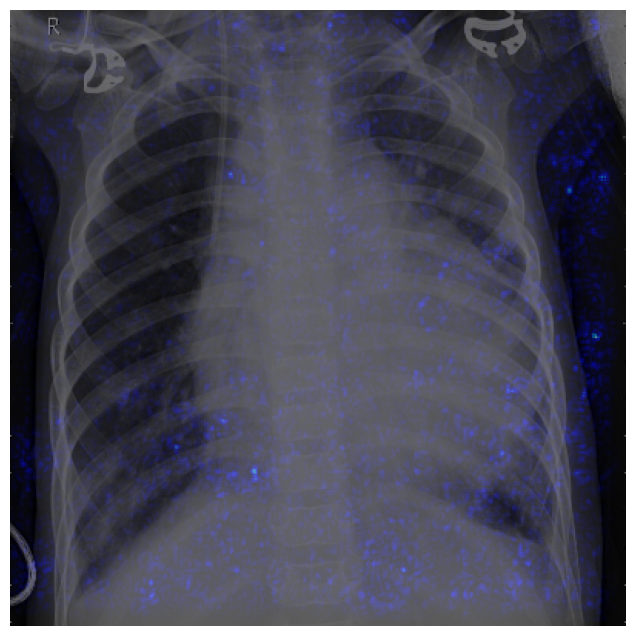

In [91]:
gradient_color = cv2.applyColorMap(normalized_tensor.numpy(), cv2.COLORMAP_HOT)
gradient_color = gradient_color / 255.0
super_imposed = cv2.addWeighted(img_saliency, 0.5, gradient_color, 0.5, 0.0)

plt.figure(figsize=(8, 8))
plt.imshow(super_imposed)
plt.axis('off')
plt.show()

## CAM model

In [92]:
model.get_layer('conv2d_93')

In [93]:
model.layers[-15]

1/1 [==============================] - 0s 24ms/step


/tmp/ipykernel_168726/2367697532.py:21: RuntimeWarning: invalid value encountered in divide
  heatmap /= np.max(heatmap)
/tmp/ipykernel_168726/2367697532.py:29: RuntimeWarning: invalid value encountered in cast
  heatmap = cv2.applyColorMap(np.uint8(255*heatmap), cv2.COLORMAP_JET)


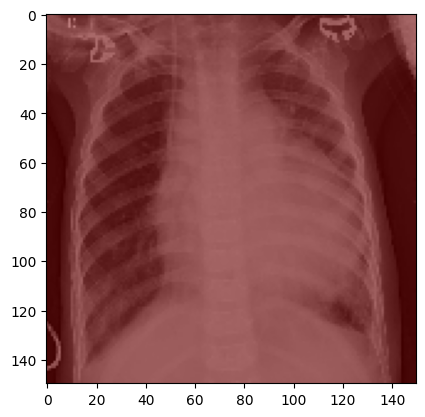

In [95]:
def gradCAM(orig, res=150):

    x = cv2.imread('./Coronahack-Chest-XRay-Dataset/test/' + orig)
    x = cv2.resize(x, (150, 150))
    x = img_saliency / 255.
    x = np.expand_dims(x, axis=0)

    preds = model.predict(x)
    #print(decode_predictions(preds)[0][0][1]) # prints the class of image

    with tf.GradientTape() as tape:
        last_conv_layer = model.get_layer('conv2d_93')
        iterate = tf.keras.models.Model([model.inputs], [model.output, last_conv_layer.output])
        model_out, last_conv_layer = iterate(x)
        class_out = model_out[:, np.argmax(model_out[0])]
        grads = tape.gradient(class_out, last_conv_layer)
        pooled_grads = K.mean(grads, axis=(0, 1, 2))
    
    heatmap = tf.reduce_mean(tf.multiply(pooled_grads, last_conv_layer), axis=-1)
    heatmap = np.maximum(heatmap, 0)
    heatmap /= np.max(heatmap)
    heatmap = heatmap.reshape((11, 11))

    img = cv2.imread('./Coronahack-Chest-XRay-Dataset/test/' + orig)
    img = cv2.resize(img, (150, 150))
    
    heatmap = cv2.resize(heatmap, (img.shape[0], img.shape[1]))

    heatmap = cv2.applyColorMap(np.uint8(255*heatmap), cv2.COLORMAP_JET)
    
    #plt.imshow(heatmap)
    #print(img)

    img = cv2.addWeighted(heatmap, 0.5, img, 0.5, 0)
    
    #print(img)

    plt.imshow(img)

gradCAM(file_name_1)

In [38]:
model